In [120]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import seaborn as sns

In [121]:
torch.cuda.is_available()

False

### confusion_matrix

In [122]:
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(loader,model, labels,device):
    with torch.inference_mode():
        test_p= []
        test_grs=[]
        for x,y in loader:
            x=x.to(device)
            preds= model(x)
            test_p += list(torch.argmax(preds,dim=1).cpu())
            test_grs += list(y)
    plt.figure(figsize=(12,9))
    sns.heatmap(confusion_matrix(test_grs, test_p),
          xticklabels= labels, yticklabels= labels, 
          cmap= "viridis",annot= True)


In [123]:
def calculate_acc(predictions, grs):
    predictions= torch.softmax(predictions,dim=1)
    predictions=torch.argmax(predictions,dim=1)
    acc= (torch.sum(predictions==grs)/len(grs)).item()
    return acc

In [124]:
from tqdm.auto import notebook_tqdm

In [160]:
def classification(train_loader,test_loader, model 
                   , criterion, optimizer, epochs, device= 'cpu'): #criterion - функция ошибок, random model
    train_loss_h=[]
    test_loss_h=[]
    
    for epoch in range(epochs):
        train_loss=0.0
        train_acc=0.0
        test_loss=0.0
        test_acc=0.0
        model.train()
        
        for x,y in train_loader: #x-картина
            x,y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            pred=model(x) 
            loss=criterion(pred,y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += calculate_acc(pred,y)
            train_loss /= len(train_loader)
            train_acc /= len(train_loader)
            train_loss_h.append(train_loss)
            
        with torch.inference_mode():
            model.eval()
            for x,y in test_loader:
                x.to(device),y.to(device) 
                test_pred=model(x)
                test_loss+=criterion(test_pred,y).item()
                test_acc+=calculate_acc(test_pred,y)
        test_loss/=len(train_loader)
        test_acc/=len(train_loader)
        test_loss_h.append(train_loss)
        print('epoch: ', epoch, '|Train loss= ', train_loss,'Acc train= ', train_acc,  '|test loss= ', test_loss,'Acc test= ', test_acc )
    return train_loss_h,test_loss_h

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои  CNN. 
* Предложить архитектуру модели для решения задачи


 download dataset

In [147]:
MNIST_TRAIN = torchvision.datasets.MNIST("data", download = True)
MNIST_TEST = torchvision.datasets.MNIST("data", download = True, train = False)

In [148]:
class Mnistdataset(Dataset):
  def __init__(self, train: bool = True, transforms = None):
    if train:
      self.X = MNIST_TRAIN.data
      self.y = MNIST_TRAIN.targets
    else:
      self.X = MNIST_TEST.data
      self.y = MNIST_TEST.targets
    self.transforms = transforms
  def __len__(self):
    return self.X.shape[0]
  def __getitem__(self, index:int):
    x = self.X[index]
    y = self.y[index]
    if self.transforms:
      x = self.transforms(x)
    x = torch.flatten(x)
    return x,y

In [149]:
mnist_transforms = torchvision.transforms.Compose([transforms.ConvertImageDtype(torch.float32),]) 

train_mnist_dataset = Mnistdataset(train=True, transforms = mnist_transforms)
test_mnist_dataset = Mnistdataset(train=False, transforms = mnist_transforms)

train_loader = DataLoader(train_mnist_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_mnist_dataset, batch_size=32)

In [150]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

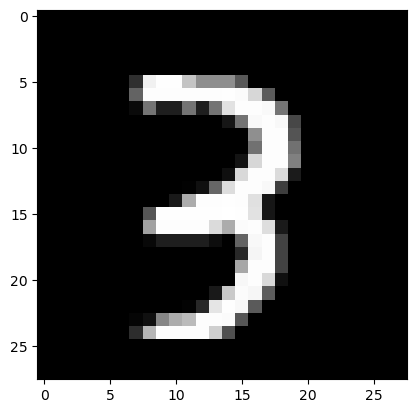

In [151]:
plt.imshow(images[0].numpy().reshape(28,28), cmap = "Greys_r")

In [152]:
class Ourmodel(nn.Module):
    def __init__(self, n_f, hid, out):
        super().__init__()
        self.l1 = nn.Linear(n_f, hid)
        self.l2= nn.Linear(hid, hid*2)
        self.l3 = nn.Linear(hid*2, out)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        out1 = self.relu(self.l1(inputs))
        out2 = self.relu(self.l2(out1))
        out3 = self.l3(out2)
        return out3

* Посчитать количество параметров модели.

In [161]:
our = Ourmodel(28*28, 20,10)
sum(p.shape[0]*p.shape[1] if len(p.shape)==2 else p.shape[0] for p in our.parameters())

16950

* Обучить модель

In [162]:
loss_ = nn.CrossEntropyLoss()
optimizer = optim.Adam(our.parameters(), lr = 0.01)
N = 20

In [159]:
history_train, history_test = classification(train_loader, test_loader, our, loss_, optimizer,N)

epoch:  0 |Train loss=  0.000335527607649871 Acc train=  0.0004002579295548454 |test loss=  0.04623066163311402 Acc test=  0.15436666666666668
epoch:  1 |Train loss=  0.00010091945176674706 Acc train=  0.0005002756931179861 |test loss=  0.04006296348520555 Acc test=  0.156
epoch:  2 |Train loss=  4.651291283167941e-05 Acc train=  0.0005335912581423798 |test loss=  0.039596769477116565 Acc test=  0.1562
epoch:  3 |Train loss=  0.0002870142006162328 Acc train=  0.00043359125815249075 |test loss=  0.04265273302781085 Acc test=  0.15493333333333334
epoch:  4 |Train loss=  0.00015113543561845604 Acc train=  0.0004836090406684836 |test loss=  0.03533469748261074 Acc test=  0.15713333333333335
epoch:  5 |Train loss=  0.00018443613139012055 Acc train=  0.00048360903593027527 |test loss=  0.044652367218708 Acc test=  0.15516666666666667
epoch:  6 |Train loss=  0.00021069713108481036 Acc train=  0.0005002668042215121 |test loss=  0.03902347152127574 Acc test=  0.15681666666666666
epoch:  7 |Trai


* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

MNISTDataset

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [163]:
class OurmodelCNN(nn.Module):
    def __init__(self, n_f, hid, out):
        super().__init__()
        self.l1 = nn.Covn2d(inputcanal, hid)
        self.l2= nn.Linear(hid, hid*2)
        self.l3 = nn.Linear(hid*2, out)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        out1 = self.relu(self.l1(inputs))
        out2 = self.relu(self.l2(out1))
        out3 = self.l3(out2)
        return out3

In [1]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()


NameError: name 'y_test' is not defined

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)